In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn import metrics
from tensorflow.keras import layers



In [2]:
# Transformer Encoder Definition
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Normalization and Multi-Head Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

In [9]:
# Load and Prepare Data
data = pd.read_csv('KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
data['ExoplanetCandidate'] = data['koi_disposition'].apply(lambda x: 1 if x == 'CANDIDATE' or x == 'CONFIRMED' else 0)

short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

data = data[short_cols].dropna()
# Define the feature columns and label
feature_columns = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet']
label_column = 'ExoplanetCandidate'

# Split the data into features and labels
X = data[feature_columns].values
y = data[label_column].values
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)

# Normalize Features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape Data for Transformer (3D Input)
x_train = tf.expand_dims(x_train, axis=-1)  # Shape: (batch_size, num_features, 1)
x_test = tf.expand_dims(x_test, axis=-1)

# Build Model with Transformer Encoder and Dense Layers
input_shape = (x_train.shape[1], 1)  # num_features, 1

In [10]:
inputs = layers.Input(shape=input_shape)
x = transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
x = layers.Flatten()(x)  # Flatten Transformer Output
x = layers.Dense(32)(x)
x = layers.LayerNormalization(axis=-1, center=True, scale=True)(x)
x = layers.Dense(16, activation='relu')(x)  # Used to be ReLU
x = layers.Dense(8, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [11]:
model = tf.keras.Model(inputs, outputs)

# Compile Model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 1)       2           ['input_1[0][0]']                


 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 1)       449         ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                                  
 dropout (Dropout)              (None, 10, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 10, 1)       0           ['dropout[0][0]',                
 da)                                                              'input_1[0][0]']                
                                                                                                  
 layer_nor

In [12]:
best_loss = 1983252378921
for i in range(1):
    # Train Model
    fitModel = model.fit(
        x_train, y_train, 
        epochs=20, batch_size=8, 
        validation_data=(x_test, y_test), 
        verbose=1
    )

    # Save History for Plotting
    history = fitModel.history

    if history['val_loss'][-1] < best_loss:
        best_loss = history['val_loss'][-1]
        model.save('NNmodel.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20


2025-08-30 15:12:43.249687: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


918/918 [==============================] - 2s 1ms/step - loss: 0.5035 - accuracy: 0.7533 - val_loss: 0.4501 - val_accuracy: 0.7843
Epoch 2/20
918/918 [==============================] - 1s 826us/step - loss: 0.4367 - accuracy: 0.7886 - val_loss: 0.4341 - val_accuracy: 0.7952
Epoch 3/20
918/918 [==============================] - 1s 825us/step - loss: 0.4230 - accuracy: 0.8005 - val_loss: 0.4230 - val_accuracy: 0.7963
Epoch 4/20
918/918 [==============================] - 1s 863us/step - loss: 0.4162 - accuracy: 0.8006 - val_loss: 0.4199 - val_accuracy: 0.7985
Epoch 5/20
918/918 [==============================] - 1s 805us/step - loss: 0.4114 - accuracy: 0.8074 - val_loss: 0.4154 - val_accuracy: 0.7968
Epoch 6/20
918/918 [==============================] - 1s 915us/step - loss: 0.4080 - accuracy: 0.8104 - val_loss: 0.4111 - val_accuracy: 0.7996
Epoch 7/20
918/918 [==============================] - 1s 841us/step - loss: 0.4050 - accuracy: 0.8085 - val_loss: 0.4129 - val_accuracy: 0.7990
Epoch

58/58 [==============================] - 0s 612us/step
F1 Score: 0.8145077720207254
Recall: 0.8247639034627492
Precision: 0.804503582395087
Accuracy: 0.8050108932461874


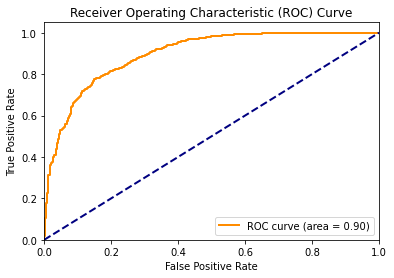

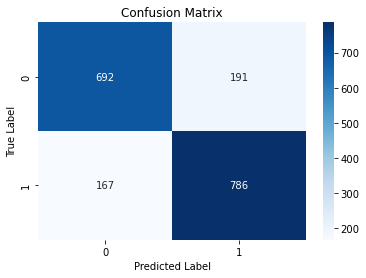

Model saved as transformer_model.h5


In [14]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute F1 score, recall and precision
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")

# Compute and plot AUC and ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the final model for prediction
model.save('transformer_model.h5')
print("Model saved as transformer_model.h5")

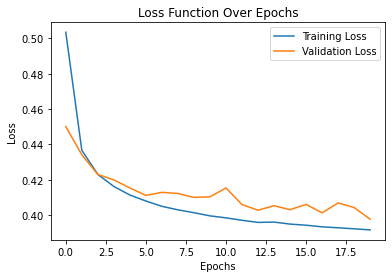

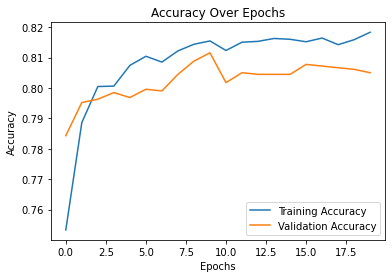

In [15]:
# Plot loss function over epochs
plt.figure()
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Over Epochs')
plt.legend()
plt.show()

# Plot accuracy over epochs
plt.figure()
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [16]:
# DO NOT USE
def evaluation(y_true, y_pred, plot=True, quiet=False):

    accuracy, recall, f1, precision = metrics.accuracy_score(y_test, y_pred), metrics.recall_score(y_test, y_pred), \
                                        metrics.f1_score(y_test, y_pred), metrics.precision_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if not quiet:
        # Print Accuracy, Recall, F1 Score, and Precision metrics.
        print('Evaluation Metrics:')
        print('Accuracy: ' + str(accuracy))
        print('Recall: ' + str(recall))
        print('F1 Score: ' + str(f1))
        print('Precision: ' + str(precision))

        # Print Confusion Matrix
        print('\nConfusion Matrix:')
        print(' TN,  FP, FN, TP')
        print(confusion_matrix(y_true, y_pred).ravel())
    
    if plot:
        # plt.figure(figsize=(13,10))
        # plt.subplot(221)
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="viridis", fmt = "d", linecolor="k", linewidths=3)
        plt.title("CONFUSION MATRIX",fontsize=20)
        plt.xlabel("Truth", fontsize=16)
        plt.ylabel("Prediction", fontsize=16)
        plt.show()

    return [accuracy, recall, f1, precision, tn, fp, fn, tp]

58/58 [==============================] - 0s 567us/step
Evaluation Metrics:
Accuracy: 0.8050108932461874
Recall: 0.8247639034627492
F1 Score: 0.8145077720207254
Precision: 0.804503582395087

Confusion Matrix:
 TN,  FP, FN, TP
[692 191 167 786]


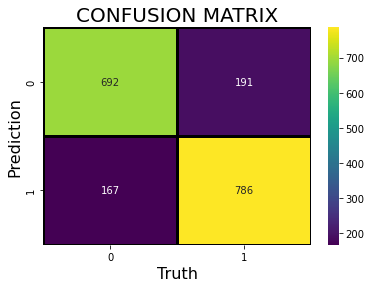

[0.8050108932461874,
 0.8247639034627492,
 0.8145077720207254,
 0.804503582395087,
 692,
 191,
 167,
 786]

In [17]:
# Custom layer to wrap tf.reduce_mean
class ReduceMeanLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)
    
# DO NOT USE
# SAVING A NEW MODEL
model.save('transformer_model.keras')

# LOADING OLD MODEL
loaded_model = tf.keras.models.load_model('transformer_model.keras', custom_objects={'ReduceMeanLayer': ReduceMeanLayer})

# Recompile the model with the desired optimizer
loaded_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

y_pred = loaded_model.predict(x_test).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

# Assuming you have an evaluation function defined
evaluation(y_test, y_pred)

In [18]:
# Check the shapes of X_test and y_test
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Make predictions
y_pred = loaded_model.predict(x_test).flatten()

# Check the shape of y_pred
print("y_pred shape:", y_pred.shape)

X_test shape: (1836, 10, 1)
y_test shape: (1836,)
58/58 [==============================] - 0s 554us/step
y_pred shape: (1836,)


In [13]:
print("Label Distribution:", np.bincount(y_train))

Label Distribution: [3684 3658]


In [13]:
import os
os.environ['PATH'] += ':/opt/homebrew/bin/'

In [15]:
from tensorflow.keras.utils import plot_model

# Plot the model with custom colors
plot_model(
    model,
    to_file="model_structure.pdf",
    # show_shapes=True,
    show_layer_names=True,
)
